# Project 1 -- Time and Global State

## Instructions

Please read carefully:

* Solve the project yourself. No teamwork.
* If you have questions, please post these in the public channel on Slack. The answers may be relevant to others as well. 
* Feel free to import and use any additional Python packages you need.
* Keep in mind that the correctness of your solution will also be verified on a *different input file*. This means that you are asked to provide an algorithm, not to hardcode the answer. If your solution for a task works only on the provided input (i.e., `sampledb.log` file), but does not work on the held back input, you will get only 50% of the points for that task.
* You are allowed to solve the project using a different programming language. In this case, please send me your full code and instructions how to run it.
* Make sure to fill in your `student_name` in the following block below.

In [9]:
student_name = 'David Mihola' # fill with your student name
assert student_name != 'your_student_name', 'Please fill in your student_name before you start.'
mattrikel_nummer = 12211951

## Setup

In this mini-project, you will use your knowledge of logical clocks to analyse a sample distributed system execution. You are given a sample log file `sampledb.log` containing an event log of five communicating processes: Alice, Bob, Carol, Dave and Eve. The log file format is as follows:
```
(<event name>)\n(<host>) (<local_clock>)
```
The code below installs the utility `gdown` and downloads `sampledb.log`.

In [10]:
# DO NOT CHANGE THESE LINES
!pip install gdown
!gdown https://drive.google.com/file/d/1s7BALY1RQyHjk06Okul7_lwUpoizZVNZ/view?usp=sharing --fuzzy

RECEIVE_EVENT = "Receive event"
SEND_EVENT = "Send event"
CHECKPOINT = "Checkpoint"
INIT_EVENT = "Init event"
MAKING_PROGRESS = "Making progress"
COMPUTING = "Computing"
NOP = "Nop"

Defaulting to user installation because normal site-packages is not writeable
Downloading...
From: https://drive.google.com/uc?id=1s7BALY1RQyHjk06Okul7_lwUpoizZVNZ
To: /mnt/sdc3/david/projs/fault_tolerant_systems/sampledb.log
100%|██████████████████████████████████████| 3.09k/3.09k [00:00<00:00, 20.0MB/s]


To inspect the `sampledb.log` file click on the folder icon in your Google Colab called `Files` on the left. 

Examples of events in the log file:
* Event `Making progress` finished on the host `Bob` at its local time 2.
```
Making progress 
Bob {"Bob":2}
```
* Event `Receive event` is a message receive event at the host `Alice` at its local clock time 3. The message comes from host `Bob` sent at its local time 2.
```
Receive event
Alice {"Alice":3, "Bob":2}
```
* Event `Checkpoint` takes place on the host `Carol` at its local time 12.
```
Checkpoint
Carol {"Carol":12}
```

The code below will help you to correctly parse the input file.

In [11]:
# DO NOT CHANGE THESE LINES
import re
import ast

regex = '(.*)\n(\S*) ({.*})'
events = []

with open(f'sampledb.log') as f:
    events = [{'event': event, 'host': host, 'clock': ast.literal_eval(clock)}
               for event, host, clock in re.findall(regex, f.read())]
print('Events:', events)
print('Total number of events:', len(events))

Events: [{'event': 'Init event', 'host': 'Alice', 'clock': {'Alice': 1}}, {'event': 'Init event', 'host': 'Bob', 'clock': {'Bob': 1}}, {'event': 'Send event', 'host': 'Alice', 'clock': {'Alice': 2}}, {'event': 'Making progress', 'host': 'Bob', 'clock': {'Bob': 2}}, {'event': 'Receive event', 'host': 'Bob', 'clock': {'Bob': 3, 'Alice': 2}}, {'event': 'Computing', 'host': 'Alice', 'clock': {'Alice': 3}}, {'event': 'Checkpoint', 'host': 'Alice', 'clock': {'Alice': 4}}, {'event': 'Making progress', 'host': 'Bob', 'clock': {'Bob': 4}}, {'event': 'Init event', 'host': 'Carol', 'clock': {'Carol': 1}}, {'event': 'Init event', 'host': 'Dave', 'clock': {'Dave': 1}}, {'event': 'Init event', 'host': 'Eve', 'clock': {'Eve': 1}}, {'event': 'Send event', 'host': 'Carol', 'clock': {'Carol': 2}}, {'event': 'Checkpoint', 'host': 'Carol', 'clock': {'Carol': 3}}, {'event': 'Send event', 'host': 'Carol', 'clock': {'Carol': 4}}, {'event': 'Send event', 'host': 'Bob', 'clock': {'Bob': 5}}, {'event': 'Receive

In [12]:
# constatnts
RECEIVE_EVENT = "Receive event"
SEND_EVENT = "Send event"
CHECKPOINT = "Checkpoint"
INIT_EVENT = "Init event"
MAKING_PROGRESS = "Making progress"
COMPUTING = "Computing"
NOP = "Nop"

## 1 - Visualize Execution [5+ points]

**Your task:** Visualize the execution (similarly to the visualizations in the lecture). The author of the best visualization gets 3 points on top!

Defaulting to user installation because normal site-packages is not writeable


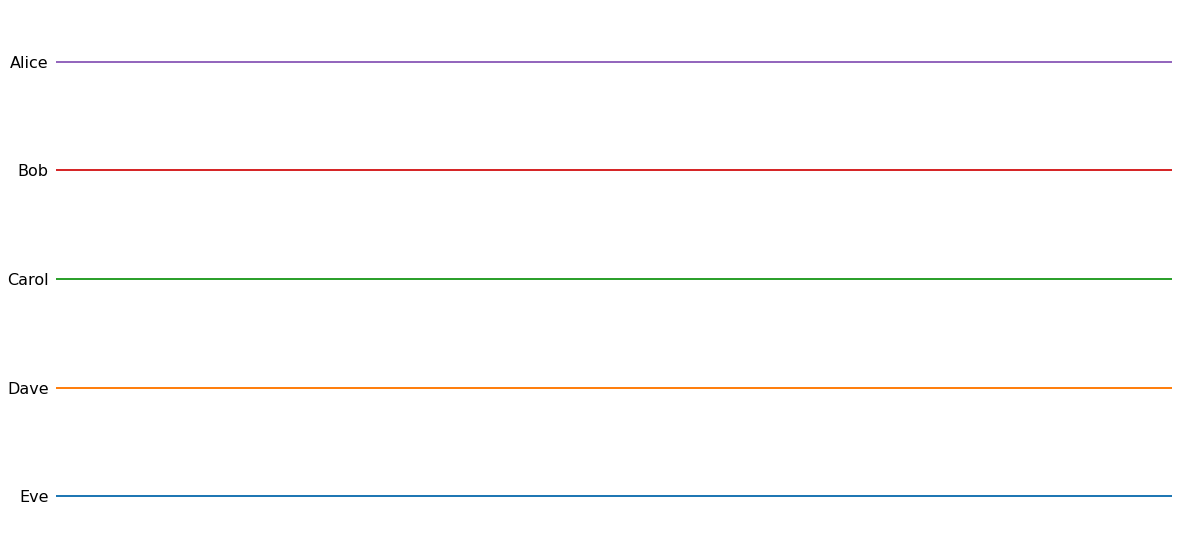

In [13]:
!pip install py-linq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from py_linq import Enumerable
import copy

events_grouped = Enumerable(events).group_by(["name"], lambda x: x["host"]).order_by(lambda x: x.key.name) # group the events by each person and order them alphabetically
names_enumerable = events_grouped.select(lambda x: x.key.name) # get the names of each person and keep the enumerable
names = names_enumerable.to_list() 

events_dict = dict( # create a dictornary from tuples
                  tuple( # make tuples ('name', 'events')
                      events_grouped.select(lambda x: [x.key.name, # name of the person
                                                       x.select(lambda y: [y["event"], list(y["clock"].items())]) # select the event name and time information into single list
                                                        .order_by(lambda y: y[1][0][1])  # events seem to be order, but might not be always the case, order them to be sure from 1 to N
                                                        .to_list() # make list of the events for one person
                                                      ]
                                           )
                                    .to_list() # make a list of lists ['name', 'events']
                        )
                  )
events_dict_without_nops = copy.deepcopy(events_dict)

for _ in range(1000): # 'while True:' would never finish, if the events are invalid
    missplaced_recieve_event = (Enumerable(events_dict.values()).select_many(lambda x: x) # make one list of events from all people
                                                                .where(lambda x: x[0] == "Receive event" and x[1][0][1] <= x[1][1][1]) # choose missplaced 'Recieve events'
                                                                .select(lambda x: x[1]) # select the time information
                                                                .order_by(lambda x: x[1][1]) # order the missplaced events by the time they happen from 1 to N
                                                                .first_or_default()) # take the first one or 'None'
    if missplaced_recieve_event == None: # no more missplaced events
        break
    
    missplaced_name = missplaced_recieve_event[0][0] # get person X, whose timeline isn't correct
    index = missplaced_recieve_event[0][1] - 1
    nops = missplaced_recieve_event[1][1] - missplaced_recieve_event[0][1] + 1 # get the number of nooperations the person X must do to correct their timeline
    timeline = events_dict[missplaced_name]
    for i in range(nops):
        timeline.insert(index, [NOP, [(missplaced_name, index + nops - i)]]) # correct the timeline
    
    for event in timeline[index + nops:]:
        event[1][0] = (event[1][0][0], event[1][0][1] + nops) 

    for name in names_enumerable.where(lambda x: x != missplaced_name): # get other people
        timeline = events_dict[name]
        for moved in Enumerable(timeline).where(lambda x: len(x[1]) > 1 and x[1][1][0] == missplaced_name and x[1][1][1] > index): # chose events affected by the change of timeline of person X
            moved[1][1] = (missplaced_name, moved[1][1][1] + nops) # adjust corrected timeline in timelines of other people

max_length = Enumerable(events_dict.values()).max(lambda x: len(x)) # find the longes timeline
for key, value in events_dict.items():
    while len(value) <= max_length:
        value.append([NOP, [(key, len(value))]]) # padd the shorter timelines

names_reversed = names.copy()
names_reversed.reverse() # to plot the names alphabetically order from top to bottom

SCALE = 20 # scale of the plot
space_width = max_length * SCALE

# configure the plot
figure, axis = plt.subplots(figsize=(20, 10))
axis.set_frame_on(False)
axis.set_xticks([], [])
axis.set_yticks(np.arange(len(names_reversed)) + 0.5, names_reversed)
axis.tick_params(labelsize=16.0, color="white")
axis.set_xlim(5, space_width + 10)
axis.set_ylim(0, len(names))
cmap_table = plt.get_cmap("tab10") # colors used by matplotlib

# create a tepmplate for a timeline of a perosn
line_x = np.linspace(5, space_width + 10, space_width + 5)
line_y = np.zeros(space_width + 5, dtype=np.uint32) + 0.5

events_coordinates = []
events_names = []
events_indices = []
events_plots = []
recieve_events_coordinates = []
recieve_events_plots = []

for i, name in enumerate(names_reversed):
    axis.plot(line_x, line_y + i, linewidth=2, color=cmap_table(i)) # plot timelines of each person with specific color

    event_coordinates = np.array(Enumerable(events_dict[name]).where(lambda x: x[0] != NOP) # don't plot 'Nop' events
                                                                               .select(lambda x: [x[1][0][1] * SCALE, i + 0.5]) # [x, y]
                                                                               .to_list()) # get a numpy array of x, y coordinates of events for the plot
    event_names = (Enumerable(events_dict_without_nops[name]).select(lambda x: f"{x[1][0][1]}. {x[0]}")
                                                             .to_list()) # get a list of event names in the same order as the coordinates for these events
    
    events_names.append(event_names) # store the names of events for the animation 
    events_indices.append([-1, -1])  # for each person initialize with invalid index

    event_plot, = axis.plot(event_coordinates[:, 0], event_coordinates[:, 1], 'o', color="black") # plot events for a person
    events_coordinates.append(event_coordinates) # store the coordiantes for animation
    events_plots.append(event_plot)              # store the plot of events for animation

recieve_events = (Enumerable(events_dict.values()).select_many(lambda x: x) # select events from every person
                                                                   .where(lambda x: x[0] == "Receive event") # select only recieve events
                                                                   .select(lambda x: [x[1][1][1] * SCALE, # x1
                                                                                      names_reversed.index(x[1][1][0]) + 0.5, # y1
                                                                                      x[1][0][1] * SCALE, # x2
                                                                                      names_reversed.index(x[1][0][0]) + 0.5, # y2
                                                                                      x[1][1][0]]) # sender
                                                                   .to_list())
for x1, y1, x2, y2, sender in recieve_events:
    span_x = x2 - x1
    recieve_event_coordinates = [x1, np.linspace(x1, x2, span_x), np.linspace(y1, y2, span_x)] # store a starting point of a line and create the line
    plot, = axis.plot(recieve_event_coordinates[1], recieve_event_coordinates[2], linewidth=1.0, 
                      color=cmap_table(names_reversed.index(sender)), marker="D", markevery=[-1], markersize=9.0) # plot the message line with the color of the sender
    recieve_events_coordinates.append(recieve_event_coordinates) # store the line info for animation
    recieve_events_plots.append(plot) # store the plot for animation

label_adjustments = [-0.22, 0.05, -0.12, 0.15] # make sure the labels don't overlap
def update(time, events_coordinates, events_plots, event_names, indices, recieve_events_coordinates, recieve_events_plots):
    for i in range(len(events_plots)):
        event_points = events_coordinates[i]
        event_points = event_points[event_points[:, 0] <= time] # get the events that should be displayed at a given time
        events_plots[i].set_data(event_points[:, 0], event_points[:, 1]) # show only these events

        if event_points.shape[0] > 0 and event_points[-1, 0] > indices[i][0]: # new event was displayed, therfore its label must be displayed as well
            indices[i][0] = event_points[-1, 0] # store the currently last event 
            indices[i][1] += 1  # update the index of the label
            height_adjust = event_points.shape[0] % 4 # put the labels of events into 4 different positions, so they don't overlap
            axis.annotate(event_names[i][indices[i][1]], (event_points[-1, 0] - 15, event_points[-1, 1] + label_adjustments[height_adjust]), fontweight="bold") # display the label
    
    for i, recieve_event_coordinates in enumerate(recieve_events_coordinates):
        x1 = recieve_event_coordinates[0]
        if time > x1: # display the message from sender to reciever
            recieve_events_plots[i].set_data(recieve_event_coordinates[1][:time - x1], recieve_event_coordinates[2][:time - x1]) # show part or the whole line
        else: # don't display the message
            recieve_events_plots[i].set_data(recieve_event_coordinates[1][:0], recieve_event_coordinates[2][:0]) # show zero points of the line

    return events_plots + recieve_events_plots # return all the plots that changed

anim = animation.FuncAnimation(figure, update, fargs=[events_coordinates, events_plots, events_names, events_indices, recieve_events_coordinates, recieve_events_plots], 
                               interval=25, blit=True, repeat=False) # animate the plot
plt.show()


# <font color=#FF0000>Run the code in the file visualisation.py, the animation does not work in a jupyter notebook.</font>

## 2 - Count Concurrent Events [5 points]

**Your task**: Count the *total number of unique* concurrent event pairs in the log file.

In [14]:
!pip install networkx
import networkx as nx

def count_concurrent_events(events, plot_graph=False): # see another approach using the vector timestamps in count_concurrent_events.py
    events_grouped = (Enumerable(events).group_by(["name"], lambda x: x["host"]) # group the events by each person
                                        .order_by(lambda x: x.key.name)) # order them alphabetically
    
    names_enumerable = events_grouped.select(lambda x: x.key.name) # select just the names
    
    name_events_enumerable = (events_grouped.select(lambda x: [x.key.name, # name of the person
                                                               x.select(lambda y: list(y["clock"].items())) # select the time information
                                                                .order_by(lambda y: y[0][1])  # events seem to be order, but might not be always the case, order them to be sure from 1 to N
                                                                .to_list() # make list of the events for the person
                                                              ]))
    
    events_dict = (dict(tuple(name_events_enumerable.to_list()))) # create a dictonary of events for each person

    G = nx.DiGraph() # create a directed graph

    for name in names_enumerable:
        previous_event = events_dict[name][0][0] # get the first event for a given person
        G.add_node(previous_event)
        for current_event in events_dict[name][1:]: # for all events from the given person apart form the first
            current_event = current_event[0]
            G.add_node(current_event) # add it to the graph
            G.add_edge(previous_event, current_event) # create a directed connection between subsequent events
            previous_event = current_event
    
    for recieve_event in (name_events_enumerable.select_many(lambda x: x[1])
                                                .where(lambda x: len(x) > 1)): # get all Receive events
        G.add_edge(recieve_event[1], recieve_event[0]) # create a directed connection between the sender and reciever

    if plot_graph: # optionally plot the graph, there are too many events, so it isn't very clear
        _, axis = plt.subplots(figsize=(15, 15))
        nx.draw(G, ax=axis, pos=nx.spring_layout(G))
        plt.show()

    concurrent_event_pairs_dict = { } # dictonary to store already found concurrent event pairs 
    pure_events_enumerable = ((Enumerable(events).select(lambda x: list(x["clock"].items())[0])))
    for event_A in pure_events_enumerable: 
        for event_B in pure_events_enumerable.where(lambda x: x != event_A): # do the cartesian product of events
            if not (concurrent_event_pairs_dict.get((event_A, event_B), False) or 
                    concurrent_event_pairs_dict.get((event_B, event_A), False)): # check if the event pair isn't already marked as concurrent
                if not (nx.has_path(G, event_A, event_B) or nx.has_path(G, event_B, event_A)): # no path from 'event_A' to 'event_B' or the other way around, therefore they must be concurrent
                    concurrent_event_pairs_dict[(event_A, event_B)] = True # mark the pair as a concurrent event pair

    return len(concurrent_event_pairs_dict) # number of concurrent event pairs is equal to the number of unique entries in the dictonary

print('Number of concurrent event pairs:', count_concurrent_events(events))

Defaulting to user installation because normal site-packages is not writeable
Number of concurrent event pairs: 1837


## 3 - Assign Vector Clocks [4 points]

**Your task:** Assign vector timestamps to each event. Annotate the event captions with the corresponting vector timestamp. E.g., 
```
`Dummy event` --> `Dummy event [0,12,2,4,0]`.
```


In [15]:
def assign_vector_timestamps(events):
    names = (Enumerable(events).group_by(["name"], lambda x: x["host"])
                               .select(lambda x: x.key.name)
                               .order_by(lambda x: x) # order alphabetically
                               .to_list()) # get names to get the size of the vector timestamp
    vector_dict = {}
    indices_dict = {}
    for i, name in enumerate(names):
        vector_dict[name] = [[0] * len(names)] # create initial vector for each person
        indices_dict[name] = i # store the 'i' index of the person

    stammed_events = []
    for event in events:
        name = event["host"]
        index = indices_dict[name]
        vector = vector_dict[name][-1].copy() # copy the last vector, from which the new vector is created
        vector[index] += 1 # 'Vi[i] = Vi[i] + 1'
        if event["event"] == RECEIVE_EVENT:
            sender = list(event["clock"].items())[1] 
            sender_vector = vector_dict[sender[0]][sender[1]] # get the sender vector at the time of sending
            final_vector = np.array([vector, sender_vector])
            final_vector = final_vector.max(axis=0) # 'max(Vmessage[j], Vi[j]) for j != i'
            final_vector[index] = vector[index] # fix the vector so 'j != i' holds
            vector = final_vector.tolist()
        
        vector_dict[name].append(vector) # store the updated vector as a new entry
        stammed_events.append(f"{event['event']} {vector}") # store the event with vector time stamp

    return "\n".join(stammed_events)

print(assign_vector_timestamps(events))

Init event [1, 0, 0, 0, 0]
Init event [0, 1, 0, 0, 0]
Send event [2, 0, 0, 0, 0]
Making progress [0, 2, 0, 0, 0]
Receive event [2, 3, 0, 0, 0]
Computing [3, 0, 0, 0, 0]
Checkpoint [4, 0, 0, 0, 0]
Making progress [2, 4, 0, 0, 0]
Init event [0, 0, 1, 0, 0]
Init event [0, 0, 0, 1, 0]
Init event [0, 0, 0, 0, 1]
Send event [0, 0, 2, 0, 0]
Checkpoint [0, 0, 3, 0, 0]
Send event [0, 0, 4, 0, 0]
Send event [2, 5, 0, 0, 0]
Receive event [0, 0, 2, 2, 0]
Checkpoint [0, 0, 2, 3, 0]
Send event [0, 0, 0, 0, 2]
Checkpoint [0, 0, 0, 0, 3]
Receive event [2, 6, 4, 0, 0]
Checkpoint [0, 0, 5, 0, 0]
Receive event [0, 0, 2, 0, 4]
Receive event [0, 0, 2, 4, 2]
Checkpoint [0, 0, 2, 5, 2]
Receive event [2, 5, 6, 0, 0]
Making progress [2, 5, 7, 0, 0]
Send event [5, 0, 0, 0, 0]
Receive event [6, 0, 4, 0, 0]
Receive event [5, 7, 4, 0, 0]
Checkpoint [5, 8, 4, 0, 0]
Send event [7, 0, 4, 0, 0]
Making progress [8, 0, 4, 0, 0]
Checkpoint [9, 0, 4, 0, 0]
Computing [0, 0, 2, 0, 5]
Processing results [0, 0, 2, 0, 6]
Check

## 4 - Rollback Recovery [6 points]
All events annotated with the `Checkpoint` in the title are checkpointing events. According to the provided log file `sampledb.log`, the hosts Alice, Bob, Carol, Dave and Eve are at their logical time 17, 22, 20, 18 and 17 respectively. Once of a sudden, Bob fails and has to rollback at least to its latest checkpoint.

**Your task:** Write an algorithm to calculate the correct recovery line given one or multiple host failures.

In [16]:
import sys

def recovery_line(events, failed_processes, verbose=False): # see another approach using the vector timestamps in recovery_line.py
    events_dict = dict(
                      tuple(
                          Enumerable(events).group_by(["name"], lambda x: x["host"]) # group the events by each person
                                            .order_by(lambda x: x.key.name) # order them alphabetically
                                            .select(lambda x: [x.key.name, # name of the person
                                                               x.select(lambda y: [y["event"]] + list(y["clock"].items())) # select the event name and time information, time is given by the number of events
                                                                .order_by(lambda y: y[1][1])  # events seem to be order, but might not be always the case, order them to be sure from 1 to N
                                                                .to_list() # make list of the events for the person
                                                              ])
                                            .to_list()
                           )
                      )

    failed_processes_dict = { name: len(events_dict[name]) for name in failed_processes } # convert the list to dictonary, to be able to use hashing for storing each name just once

    for receiver, sender in (Enumerable(events).where(lambda x: x["event"] == RECEIVE_EVENT)
                                               .select(lambda x: list(x["clock"].items()))):
        events_dict[sender[0]][sender[1] - 1].append(receiver) # add recievers to all send events
    
    while len(failed_processes_dict): # until there are failed processes
        canceled_send_events = []
        for name, time in failed_processes_dict.items():
            timeline = events_dict[name]
            while len(timeline) > time or (timeline[-1][0] != CHECKPOINT and timeline[-1][0] != INIT_EVENT): # rollback to either of these events
                if timeline[-1][0] == SEND_EVENT:
                    canceled_send_events.append(timeline[-1][2:]) # store all recievers of send events, which didn't happen due to rollback
                timeline.pop()

        failed_processes_dict = {} # all failed processes were rolled back, clear them
        for canceled_send_event in canceled_send_events:
            for receiver, time in canceled_send_event:
                if len(events_dict[receiver]) >= time and time < failed_processes_dict.get(receiver, sys.maxsize): # reciever received message, that wasn't send, and when receiving multiple of these, he must rollback to the first of them
                    failed_processes_dict[receiver] = time  # reciever must rollback at least to this time

    if verbose:
        return "\n" + "\n".join([f"{events[-1][0]} from {events[-1][1][0]} at time {events[-1][1][1]}" for events in events_dict.values()])
    else:
        return [events[-1][1][1] for events in events_dict.values()]

print("Computed recovery line: ", recovery_line(events, ["Bob"], verbose=False)) # set 'verbose' to True for enhanced print

Computed recovery line:  [13, 21, 14, 14, 13]


## 5 - How to Submit Your Solution?
Download your notebook (File --> Download --> Download .ipynb) and send per email to [saukh@tugraz.at](mailto:saukh@tugraz.at).